In [1]:
import pandas as pd
import numpy as np

# 데이터 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 가설검정 및 통계 분석 패키지
from scipy import stats

# 선형모델 formula ( y ~ x1 + x2 + ...)
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression
from statsmodels.api import qqplot, add_constant

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.anova import anova_lm

# 변수 선택법(후진제거법)
from sklearn.feature_selection import RFE

# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Scale변환 -> 표준화 회귀계수 산출
## coefficient를 표준화해서 비교해본다.
from sklearn.preprocessing import StandardScaler

# grhpviz
from sklearn.tree import export_graphviz

import graphviz

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV


# 주피터 노트북 사용시 그래프 자동 출력 옵션
%matplotlib inline

matplotlib.rc('font', family = "NanumGothic")
plt.rc('font', family = "NanumGothic")
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df_raw = pd.read_csv("./Data/체질검사.csv")
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [3]:
df_raw_y = df_raw["FAT"]
df_raw_x = df_raw.drop("FAT", axis=1, inplace = False)

In [1]:
# train_test_split (7:3으로 트레인과 테스트 데이터가 나눠진다.)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, 
                                                                test_size=0.3, random_state=1234)

print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

NameError: name 'train_test_split' is not defined

In [5]:
tree_uncustomized = DecisionTreeRegressor(random_state=1234)
tree_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))

#test데이터 설명력
print("Score on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 1.000
Score on test set: 0.345


※ 순수 잎사귀까지 봤기 때문에 트레이닝은 100%가 된다. 하지만 그에 반해 test 데이터의 설명력은 아주 낮다. overfitting이 발생했다.

# 2. 모델 parameter 조정

## 이파리 노드 최소 자료 수
- min_sample_leaf: 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [6]:
train_score = []; test_score = []

para_leaf = [n_leaf * 1 for n_leaf in range(1, 20)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSampleLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

In [7]:
df_score_leaf.round(3)

,MinSampleLeaf,TrainScore,TestScore
0,1,1.000,0.345
1,2,0.970,0.374
2,3,0.928,0.445
3,4,0.902,0.447
4,5,0.868,0.451
5,6,0.851,0.447
6,7,0.843,0.465
7,8,0.830,0.536
8,9,0.802,0.477
9,10,0.793,0.505


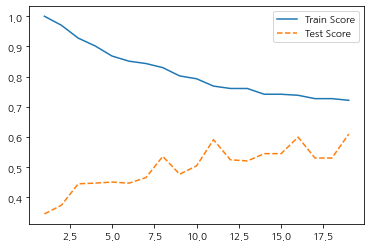

In [8]:
plt.plot(para_leaf, train_score, linestyle="-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle="--", label = "Test Score")
plt.legend()

## 3. 트리 시각화

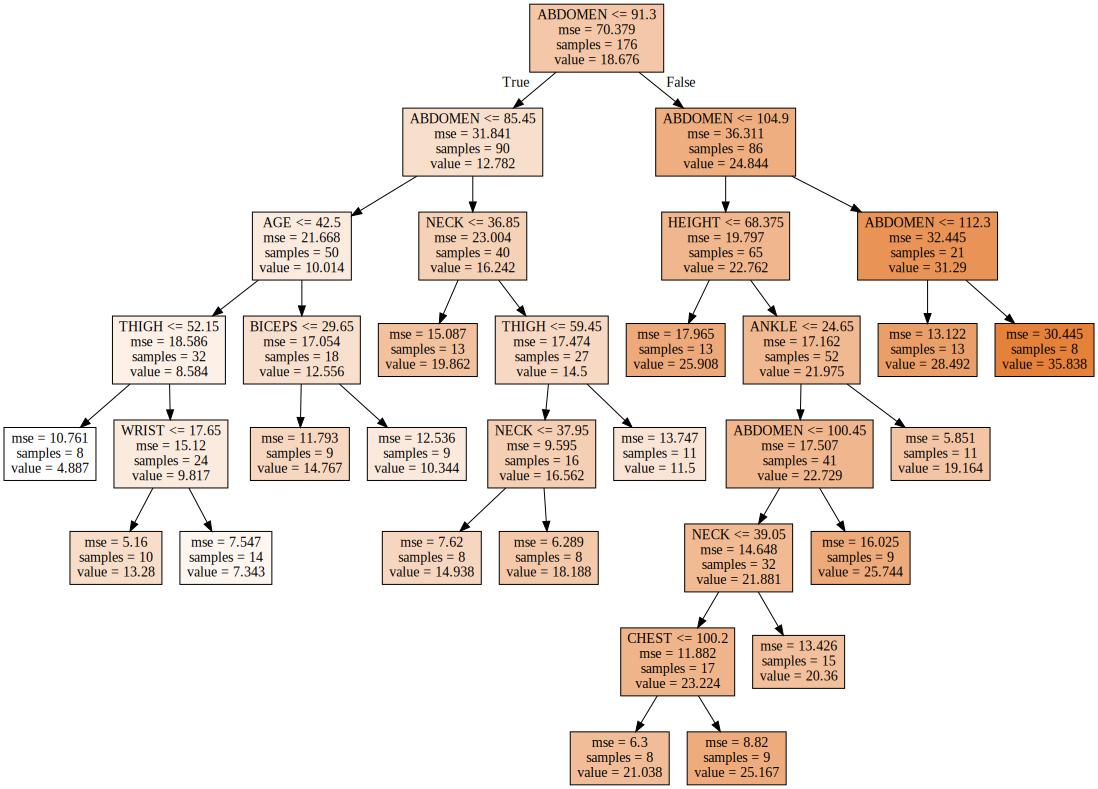

In [9]:
v_feature_name = df_train_x.columns

# 잎사귀 설정 (노드 수 8)
tree_graph = DecisionTreeRegressor(min_samples_leaf = 8, random_state=1234)
tree_graph.fit(df_train_x, df_train_y)

## Tree 구조 생성 및 저장: 모델 시각화
export_graphviz(tree_graph, out_file = "tree_leaf.dot", feature_names = v_feature_name,
                impurity=True, filled = True) # filled 색으로 영향력 표시

with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

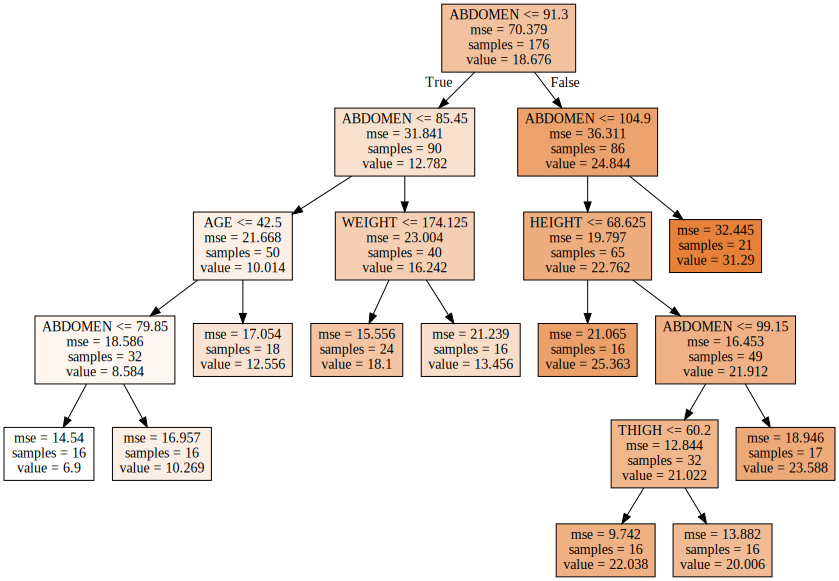

In [10]:
v_feature_name = df_train_x.columns

# 잎사귀 설정 (노드 수 16)
tree_graph = DecisionTreeRegressor(min_samples_leaf = 16, random_state=1234)
tree_graph.fit(df_train_x, df_train_y)

## Tree 구조 생성 및 저장: 모델 시각화
export_graphviz(tree_graph, out_file = "tree_leaf.dot", feature_names = v_feature_name,
                impurity=True, filled = True) # filled 색으로 영향력 표시

with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

※ 16은 너무 적으니 8정도로 생각하고 넘어가면 된다.

## 최소 자료수의 범위만 설정(split)

In [11]:
train_score = []
test_score = []
para_split = [n_leaf * 2 for n_leaf in range(2, 20)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf=8,
                                 min_samples_split=v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

In [12]:
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.830,0.536
1,6,0.830,0.536
2,8,0.830,0.536
3,10,0.830,0.536
4,12,0.830,0.536
5,14,0.830,0.536
6,16,0.830,0.536
7,18,0.821,0.557
8,20,0.813,0.581
9,22,0.792,0.567


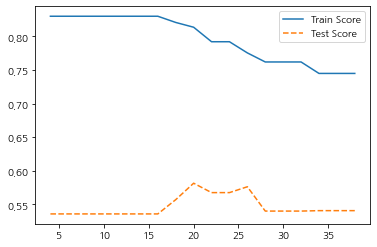

In [13]:
plt.plot(para_split, train_score, linestyle="-", label = "Train Score")
plt.plot(para_split, test_score, linestyle="--", label = "Test Score")
plt.legend()

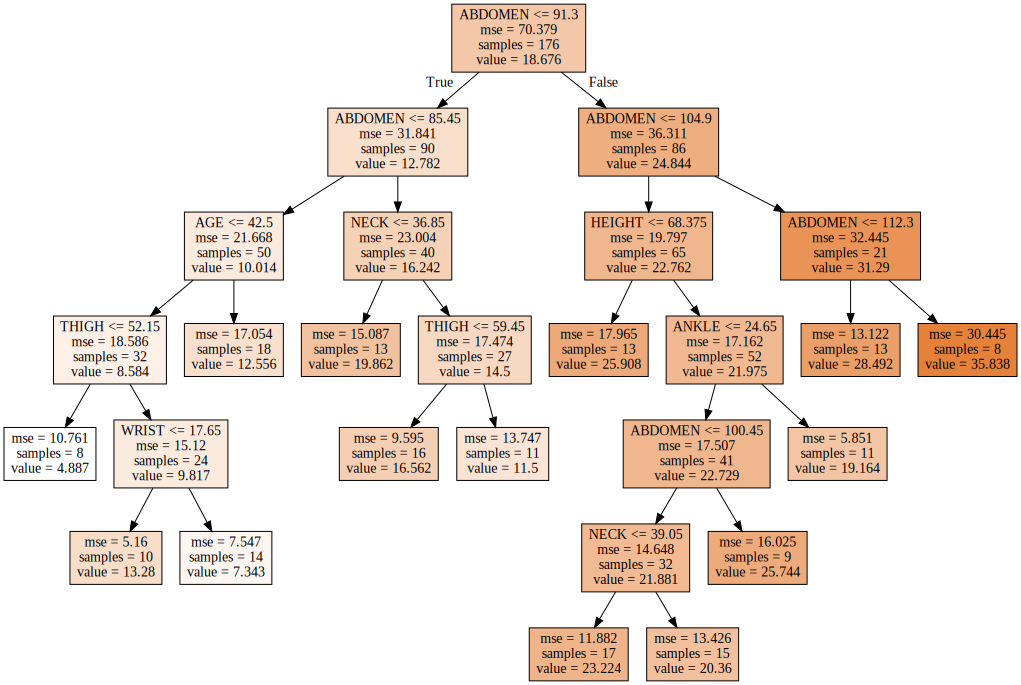

In [14]:
v_feature_name = df_train_x.columns

# 분리노드의 최소 자료수 설정 (노드 수 16)
tree_graph = DecisionTreeRegressor(min_samples_leaf = 8, min_samples_split=20, random_state=1234)
tree_graph.fit(df_train_x, df_train_y)

## Tree 구조 생성 및 저장: 모델 시각화
export_graphviz(tree_graph, out_file = "tree_leaf.dot", feature_names = v_feature_name,
                impurity=True, filled = True) # filled 색으로 영향력 표시

with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 20은 과소적합

## 깊이 지정(depth)

In [15]:
train_score = []; test_score = []

para_depth = [depth for depth in range(1, 10)]

for v_max_depth in para_depth:
    tree = DecisionTreeRegressor(random_state=1234, max_depth=v_max_depth,
                                 min_samples_leaf=8, min_samples_split=20)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_depth = pd.DataFrame()
df_score_depth["MaxDepth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

In [16]:
df_score_depth.round(3)

,MaxDepth,TrainScore,TestScore
0,1,0.517,0.333
1,2,0.679,0.569
2,3,0.749,0.538
3,4,0.783,0.570
4,5,0.808,0.581
5,6,0.813,0.581
6,7,0.813,0.581
7,8,0.813,0.581
8,9,0.813,0.581


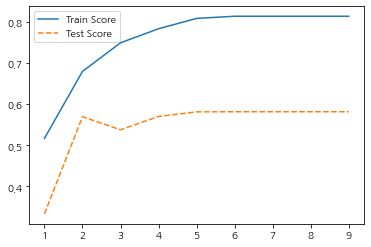

In [17]:
plt.plot(para_depth, train_score, linestyle="-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle="--", label = "Test Score")
plt.legend()

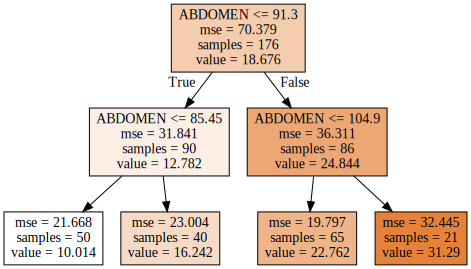

In [18]:
# 언더피팅이 발생된다

v_feature_name = df_train_x.columns

# 최대깊이 = 2
tree_graph = DecisionTreeRegressor(min_samples_leaf = 8, min_samples_split=20,
                                   max_depth=2, random_state=1234)
tree_graph.fit(df_train_x, df_train_y)

## Tree 구조 생성 및 저장: 모델 시각화
export_graphviz(tree_graph, out_file = "tree_leaf.dot", feature_names = v_feature_name,
                impurity=True, filled = True) # filled 색으로 영향력 표시

with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

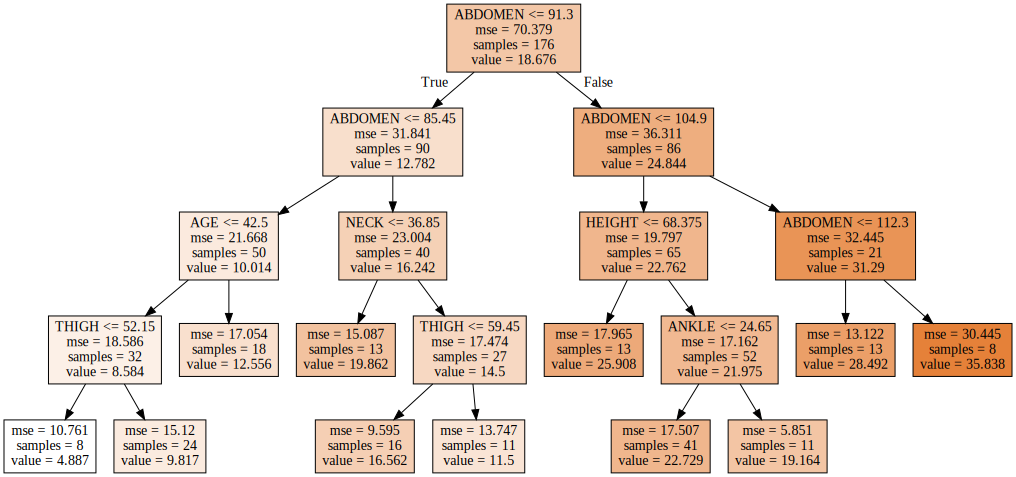

In [19]:
v_feature_name = df_train_x.columns

# 최대깊이 = 4
tree_graph = DecisionTreeRegressor(min_samples_leaf=8, min_samples_split=20,
                                   max_depth=4, random_state=1234)
tree_graph.fit(df_train_x, df_train_y)

## Tree 구조 생성 및 저장: 모델 시각화
export_graphviz(tree_graph, out_file = "tree_leaf.dot", feature_names = v_feature_name,
                impurity=True, filled = True) # filled 색으로 영향력 표시

with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

## 3. 최종모델 설정

In [20]:
tree_final = DecisionTreeRegressor(min_samples_leaf= 8, min_samples_split=20, 
                                   max_depth=4,random_state=1234)
tree_final.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(tree_final.score(df_train_x, df_train_y)))

#test데이터 설명력
print("Score on test set: {:.3f}".format(tree_final.score(df_test_x, df_test_y)))

Score on training set: 0.783
Score on test set: 0.570


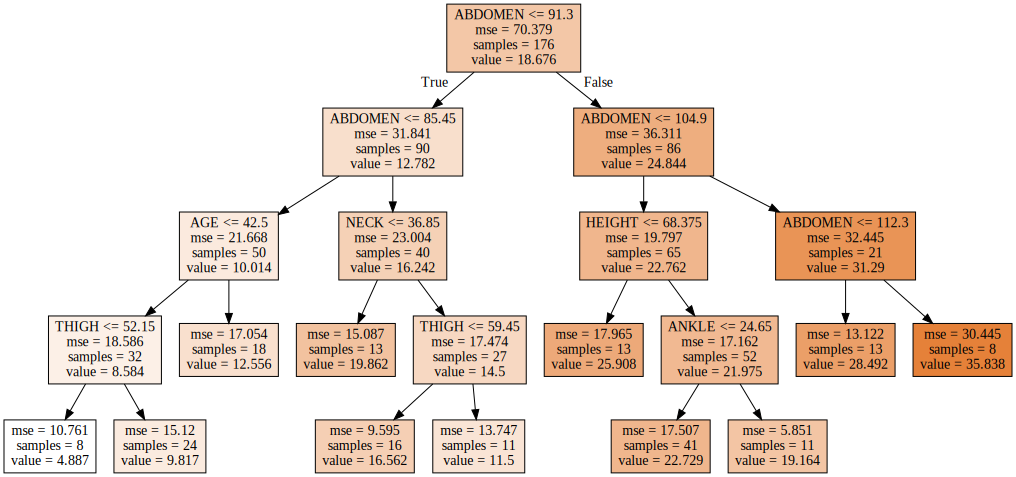

In [25]:
export_graphviz(tree_final, out_file = "tree_leaf.dot", feature_names = v_feature_name,
                impurity=True, filled = True) # filled 색으로 영향력 표시

with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

※ 트리모델 시각화 및 해석
- 트리 분리에 영향이 큰 변수는 ABDOMEN, AGE, NECK 등
- MSE를 줄이는 쪽으로 분리가 일어난다.

## 4. 결론 도출

In [22]:
df_importance = pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"] = tree_final.feature_importances_


df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
5,ABDOMEN,0.895
7,THIGH,0.032
3,NECK,0.026
0,AGE,0.019
2,HEIGHT,0.017
9,ANKLE,0.011
1,WEIGHT,0.000
4,CHEST,0.000
6,HIP,0.000
8,KNEE,0.000


Text(0, 0.5, '변수')

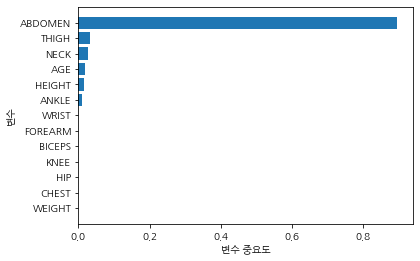

In [23]:
df_importance.sort_values("Importance", ascending= True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

## 참고. GridSearchCV
- p.188

In [24]:
estimator = DecisionTreeRegressor()

# 리프 노드 수
para_leaf = [n_leaf * 1 for n_leaf in range(1, 20)]
# 스플릿 최소 자료 수
para_split = [n_leaf * 2 for n_leaf in range(2, 20)]
# 트리 깊이
para_depth = [depth for depth in range(1, 10)]


# criterion은 mae와 mse만 비교
# "max_feature":["auto", "sqrt", "log2"]는 의사결정나무에 해당 X
param_grid = {"criterion": ["mse", "mae"],
              "max_depth": para_depth, "min_samples_split": para_split, 
              "min_samples_leaf": para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs=-1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("best parmater: \n{}".format(grid_dt.best_params_))
print("nbest score: \n{}".format(grid_dt.best_score_.round(3)))

ValueError: Invalid parameter max_feature for estimator DecisionTreeRegressor(max_depth=1). Check the list of available parameters with `estimator.get_params().keys()`.